<a href="https://colab.research.google.com/gist/janlukasschroeder/3da274150fd00c1c1776c7e541a9b61b/extracting-financial-statements-from-sec-filings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Financial Statements from SEC Filings - XBRL-To-JSON

This is the entire Jupyter notebook to extract financial statements from annual and quarterly reports as reported in 10-K and 10-Q filings with the SEC.

We use https://sec-api.io to get all 10-K and 10-Q filings and to convert their XBRL data into JSON so that we can create a single income statement, balance sheet and cash flow statement for Apple, covering quarterly financial data over multiple years.

Medium article:
https://medium.com/@jan_5421/extracting-financial-statements-from-sec-filings-xbrl-to-json-f83542ade90

In [1]:
# uncomment the next line to install the SEC API Python package
# pip install sec-api

In [2]:
# get your free API key at https://sec-api.io
api_key = ""

In [3]:
import requests
import json
import pandas as pd

# 10-Q filing URL of Apple
filing_url = "https://www.sec.gov/Archives/edgar/data/789019/000156459022035087/msft-20220930.htm"

# https://www.sec.gov/Archives/edgar/data/789019/000156459022035087/msft-20220930.htm


# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(json.dumps(xbrl_json['StatementsOfIncome']))

{"WeightedAverageNumberOfDilutedSharesOutstanding": [{"decimals": "-6", "unitRef": "U_xbrlishares", "period": {"startDate": "2022-07-01", "endDate": "2022-09-30"}, "value": "7485000000"}, {"decimals": "-6", "unitRef": "U_xbrlishares", "period": {"startDate": "2021-07-01", "endDate": "2021-09-30"}, "value": "7567000000"}], "WeightedAverageNumberOfSharesOutstandingBasic": [{"decimals": "-6", "unitRef": "U_xbrlishares", "period": {"startDate": "2022-07-01", "endDate": "2022-09-30"}, "value": "7457000000"}, {"decimals": "-6", "unitRef": "U_xbrlishares", "period": {"startDate": "2021-07-01", "endDate": "2021-09-30"}, "value": "7513000000"}], "EarningsPerShareDiluted": [{"decimals": "2", "unitRef": "U_iso4217USD_xbrlishares", "period": {"startDate": "2022-07-01", "endDate": "2022-09-30"}, "value": "2.35"}, {"decimals": "2", "unitRef": "U_iso4217USD_xbrlishares", "period": {"startDate": "2021-07-01", "endDate": "2021-09-30"}, "value": "2.71"}, {"decimals": "2", "unitRef": "U_iso4217USD_xbrlis

In [4]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)

In [5]:
income_statement

,2022-07-01-2022-09-30,2021-07-01-2021-09-30
WeightedAverageNumberOfDilutedSharesOutstanding,7485000000,7567000000
WeightedAverageNumberOfSharesOutstandingBasic,7457000000,7513000000
EarningsPerShareDiluted,2.35,2.71
EarningsPerShareBasic,2.35,2.73
NetIncomeLoss,17556000000,20505000000
IncomeTaxExpenseBenefit,4016000000,19000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,21572000000,20524000000
NonoperatingIncomeExpense,54000000,286000000
OperatingIncomeLoss,21518000000,20238000000
GeneralAndAdministrativeExpense,1398000000,1287000000


In [6]:

# convert XBRL-JSON of balance sheet to pandas dataframe
def get_balance_sheet(xbrl_json):
    balance_sheet_store = {}

    for usGaapItem in xbrl_json['BalanceSheets']:
        values = []
        indicies = []

        for fact in xbrl_json['BalanceSheets'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                index = fact['period']['instant']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue
                    
                # add 0 if value is nil
                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

            balance_sheet_store[usGaapItem] = pd.Series(values, index=indicies) 

    balance_sheet = pd.DataFrame(balance_sheet_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date instant
    return balance_sheet.T

balance_sheet = get_balance_sheet(xbrl_json)

In [7]:
balance_sheet

,2021-09-30,2022-06-30,2022-09-30
LiabilitiesAndStockholdersEquity,NaN,364840000000,359784000000
StockholdersEquity,151978000000,166542000000,173566000000
AccumulatedOtherComprehensiveIncomeLossNetOfTax,NaN,-4678000000,-7343000000
RetainedEarningsAccumulatedDeficit,NaN,84281000000,92374000000
CommonStocksIncludingAdditionalPaidInCapital,NaN,86939000000,88535000000
CommitmentsAndContingencies,NaN,0.0,0.0
Liabilities,NaN,198298000000,186218000000
OtherLiabilitiesNoncurrent,NaN,15526000000,15311000000
OperatingLeaseLiabilityNoncurrent,NaN,11489000000,11660000000
DeferredIncomeTaxLiabilitiesNet,NaN,230000000,223000000


In [8]:
balance_sheet.T

,LiabilitiesAndStockholdersEquity,StockholdersEquity,AccumulatedOtherComprehensiveIncomeLossNetOfTax,RetainedEarningsAccumulatedDeficit,CommonStocksIncludingAdditionalPaidInCapital,CommitmentsAndContingencies,Liabilities,OtherLiabilitiesNoncurrent,OperatingLeaseLiabilityNoncurrent,DeferredIncomeTaxLiabilitiesNet,...,LongTermInvestments,OperatingLeaseRightOfUseAsset,PropertyPlantAndEquipmentNet,AssetsCurrent,OtherAssetsCurrent,InventoryNet,AccountsReceivableNetCurrent,CashCashEquivalentsAndShortTermInvestments,ShortTermInvestments,CashAndCashEquivalentsAtCarryingValue
2021-09-30,NaN,151978000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,364840000000,166542000000,-4678000000,84281000000,86939000000,0.0,198298000000,15526000000,11489000000,230000000,...,6891000000,13148000000,74398000000,169684000000,16924000000,3742000000,44261000000,104757000000,90826000000,13931000000
2022-09-30,359784000000,173566000000,-7343000000,92374000000,88535000000,0.0,186218000000,15311000000,11660000000,223000000,...,6839000000,13347000000,77037000000,160812000000,18003000000,4268000000,31279000000,107262000000,84378000000,22884000000


In [9]:

def get_cash_flow_statement(xbrl_json):
    cash_flows_store = {}

    for usGaapItem in xbrl_json['StatementsOfCashFlows']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfCashFlows'][usGaapItem]:        
            # only consider items without segment.
            if 'segment' not in fact:
                # check if date instant or date range is present
                if "instant" in fact['period']:
                    index = fact['period']['instant']
                else:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

        cash_flows_store[usGaapItem] = pd.Series(values, index=indicies) 


    cash_flows = pd.DataFrame(cash_flows_store)
    return cash_flows.T
    
cash_flows = get_cash_flow_statement(xbrl_json)

In [10]:
cash_flows

,2021-06-30,2021-07-01-2021-09-30,2021-09-30,2022-06-30,2022-07-01-2022-09-30,2022-09-30
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents,14224000000,NaN,19165000000,13931000000,NaN,22884000000
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,NaN,4941000000,NaN,NaN,8953000000,NaN
EffectOfExchangeRateOnCashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsIncludingDisposalGroupAndDiscontinuedOperations,NaN,-73000000,NaN,NaN,-230000000,NaN
NetCashProvidedByUsedInInvestingActivities,NaN,-3250000000,NaN,NaN,-3132000000,NaN
PaymentsForProceedsFromOtherInvestingActivities,NaN,417000000,NaN,NaN,860000000,NaN
ProceedsFromInvestments,NaN,5630000000,NaN,NaN,2711000000,NaN
ProceedsFromMaturitiesPrepaymentsAndCallsOfAvailableForSaleSecurities,NaN,8862000000,NaN,NaN,6662000000,NaN
PaymentsToAcquireInvestments,NaN,10309000000,NaN,NaN,5013000000,NaN
AcquisitionsNetOfCashAcquiredAndPurchasesOfIntangibleAndOtherAssets,NaN,1206000000,NaN,NaN,349000000,NaN
PaymentsToAcquirePropertyPlantAndEquipment,NaN,5810000000,NaN,NaN,6283000000,NaN


In [17]:
from sec_api import QueryApi

# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

# fetch all 10-Q and 10-K filings for Apple
query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:MSFT"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

In [18]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);

accession_numbers

['0001564590-22-035087',
 '0001564590-22-026876',
 '0001564590-22-015675',
 '0001564590-22-002324',
 '0001564590-21-051992',
 '0001564590-21-039151',
 '0001564590-21-020891',
 '0001564590-21-002316',
 '0001564590-20-047996',
 '0001564590-20-034944',
 '0001564590-20-019706',
 '0001564590-20-002450',
 '0001564590-19-037549',
 '0001564590-19-027952',
 '0001564590-19-012709',
 '0001564590-19-001392',
 '0001564590-18-024893',
 '0001564590-18-019062',
 '0001564590-18-009307',
 '0001564590-18-001129']

In [19]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

In [20]:
# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [21]:
# merge two income statements into one statement.
# row indicies of both statements have to be the same
# statement_b represents the most recent statement.
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                    #  on=statement_b.index, 
                    right_on=statement_b.index, 
                     left_index=True,
                    #  right_index=True,
                     suffixes=('_left', ''))

In [22]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers[0:12]:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    # display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Processing: 0001564590-22-035087
Processing: 0001564590-22-026876
Processing: 0001564590-22-015675
Processing: 0001564590-22-002324
Processing: 0001564590-21-051992
Processing: 0001564590-21-039151
Processing: 0001564590-21-020891
Processing: 0001564590-21-002316
Processing: 0001564590-20-047996
Processing: 0001564590-20-034944
Processing: 0001564590-20-019706
Processing: 0001564590-20-002450


In [23]:
income_statement_final

,2017-07-01-2018-06-30,2018-07-01-2018-12-31,2018-07-01-2019-03-31,2018-07-01-2019-06-30,2018-10-01-2018-12-31,2019-01-01-2019-03-31,2019-07-01-2019-09-30,2019-07-01-2019-12-31,2019-07-01-2020-03-31,2019-07-01-2020-06-30,...,2020-07-01-2021-06-30,2020-10-01-2020-12-31,2021-01-01-2021-03-31,2021-07-01-2021-09-30,2021-07-01-2021-12-31,2021-07-01-2022-03-31,2021-07-01-2022-06-30,2021-10-01-2021-12-31,2022-01-01-2022-03-31,2022-07-01-2022-09-30
WeightedAverageNumberOfDilutedSharesOutstanding,7794000000,7767000000,7759000000,7753000000,7768000000,7744000000,7710000000,7701000000,7693000000,7683000000,...,7608000000,7616000000,7597000000,7567000000,7561000000,7552000000,7540000000,7555000000,7534000000,7485000000
WeightedAverageNumberOfSharesOutstandingBasic,7700000000,7683000000,7679000000,7673000000,7692000000,7672000000,7634000000,7628000000,7619000000,7610000000,...,7547000000,7555000000,7539000000,7513000000,7509000000,7504000000,7496000000,7505000000,7493000000,7457000000
EarningsPerShareDiluted,2.13,2.22,3.36,5.06,1.08,1.14,1.38,2.90,4.30,5.76,...,8.05,2.03,2.03,2.71,5.19,7.41,9.65,2.48,2.22,2.35
EarningsPerShareBasic,2.15,2.24,3.39,5.11,1.09,1.15,1.40,2.93,4.34,5.82,...,8.12,2.05,2.05,2.73,5.23,7.46,9.70,2.50,2.23,2.35
NetIncomeLoss,16571000000,17244000000,26053000000,39240000000,8420000000,8809000000,10678000000,22327000000,33079000000,44281000000,...,61271000000,15463000000,15457000000,20505000000,39270000000,55998000000,72738000000,18765000000,16728000000,17556000000
IncomeTaxExpenseBenefit,19903000000,3362000000,5039000000,4448000000,1965000000,1677000000,2008000000,4444000000,6535000000,8755000000,...,9831000000,2874000000,1779000000,19000000,3769000000,7231000000,10978000000,3750000000,3462000000,4016000000
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,43039000000,63229000000,83716000000,22515000000,20190000000,21572000000
NonoperatingIncomeExpense,1416000000,393000000,538000000,729000000,127000000,145000000,0,194000000,62000000,77000000,...,1186000000,440000000,188000000,286000000,554000000,380000000,333000000,268000000,-174000000,54000000
OperatingIncomeLoss,35058000000,20213000000,30554000000,42959000000,10258000000,10341000000,12686000000,26577000000,39552000000,52959000000,...,69916000000,17897000000,17048000000,20238000000,42485000000,62849000000,83383000000,22247000000,20364000000,21518000000
GeneralAndAdministrativeExpense,4754000000,2281000000,3460000000,4885000000,1132000000,1179000000,1061000000,2182000000,3455000000,5111000000,...,5107000000,1139000000,1327000000,1287000000,2671000000,4151000000,5900000000,1384000000,1480000000,1398000000


In [24]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].iteritems():
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [25]:
statement = income_statement_final
statement_1 = add_fourth_quarter_results(statement)

In [26]:
statement_1

,2017-07-01-2018-06-30,2018-07-01-2018-12-31,2018-07-01-2019-03-31,2018-07-01-2019-06-30,2018-10-01-2018-12-31,2019-01-01-2019-03-31,2019-03-31-2019-06-30,2019-07-01-2019-09-30,2019-07-01-2019-12-31,2019-07-01-2020-03-31,...,2021-01-01-2021-03-31,2021-03-31-2021-06-30,2021-07-01-2021-09-30,2021-07-01-2021-12-31,2021-07-01-2022-03-31,2021-07-01-2022-06-30,2021-10-01-2021-12-31,2022-01-01-2022-03-31,2022-03-31-2022-06-30,2022-07-01-2022-09-30
WeightedAverageNumberOfDilutedSharesOutstanding,7794000000,7767000000,7759000000,7753000000,7768000000,7744000000,7753000000,7710000000,7701000000,7693000000,...,7597000000,7608000000,7567000000,7561000000,7552000000,7540000000,7555000000,7534000000,7540000000,7485000000
WeightedAverageNumberOfSharesOutstandingBasic,7700000000,7683000000,7679000000,7673000000,7692000000,7672000000,7673000000,7634000000,7628000000,7619000000,...,7539000000,7547000000,7513000000,7509000000,7504000000,7496000000,7505000000,7493000000,7496000000,7457000000
EarningsPerShareDiluted,2.13,2.22,3.36,5.06,1.08,1.14,1.7,1.38,2.90,4.30,...,2.03,2.16,2.71,5.19,7.41,9.65,2.48,2.22,2.22,2.35
EarningsPerShareBasic,2.15,2.24,3.39,5.11,1.09,1.15,1.72,1.40,2.93,4.34,...,2.05,2.18,2.73,5.23,7.46,9.70,2.50,2.23,2.23,2.35
NetIncomeLoss,16571000000,17244000000,26053000000,39240000000,8420000000,8809000000,13187000000,10678000000,22327000000,33079000000,...,15457000000,16458000000,20505000000,39270000000,55998000000,72738000000,18765000000,16728000000,16740000000,17556000000
IncomeTaxExpenseBenefit,19903000000,3362000000,5039000000,4448000000,1965000000,1677000000,-591000000,2008000000,4444000000,6535000000,...,1779000000,2947000000,19000000,3769000000,7231000000,10978000000,3750000000,3462000000,3747000000,4016000000
NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,...,NaN,nan,NaN,43039000000,63229000000,83716000000,22515000000,20190000000,20487000000,21572000000
NonoperatingIncomeExpense,1416000000,393000000,538000000,729000000,127000000,145000000,191000000,0,194000000,62000000,...,188000000,310000000,286000000,554000000,380000000,333000000,268000000,-174000000,-47000000,54000000
OperatingIncomeLoss,35058000000,20213000000,30554000000,42959000000,10258000000,10341000000,12405000000,12686000000,26577000000,39552000000,...,17048000000,19095000000,20238000000,42485000000,62849000000,83383000000,22247000000,20364000000,20534000000,21518000000
GeneralAndAdministrativeExpense,4754000000,2281000000,3460000000,4885000000,1132000000,1179000000,1425000000,1061000000,2182000000,3455000000,...,1327000000,1522000000,1287000000,2671000000,4151000000,5900000000,1384000000,1480000000,1749000000,1398000000


In [27]:
# remove all non-quarterly columns
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

In [28]:
qrt_income_statement = only_quarterly_results(statement_1)
qrt_income_statement

,2018-10-01-2018-12-31,2019-01-01-2019-03-31,2019-03-31-2019-06-30,2019-07-01-2019-09-30,2019-10-01-2019-12-31,2020-01-01-2020-03-31,2020-03-31-2020-06-30,2020-07-01-2020-09-30,2020-10-01-2020-12-31,2021-01-01-2021-03-31,2021-03-31-2021-06-30,2021-07-01-2021-09-30,2021-10-01-2021-12-31,2022-01-01-2022-03-31,2022-03-31-2022-06-30,2022-07-01-2022-09-30
WeightedAverageNumberOfDilutedSharesOutstanding,7768000000,7744000000,7753000000,7710000000,7691000000,7675000000,7683000000,7637000000,7616000000,7597000000,7608000000,7567000000,7555000000,7534000000,7540000000,7485000000
WeightedAverageNumberOfSharesOutstandingBasic,7692000000,7672000000,7673000000,7634000000,7621000000,7602000000,7610000000,7566000000,7555000000,7539000000,7547000000,7513000000,7505000000,7493000000,7496000000,7457000000
EarningsPerShareDiluted,1.08,1.14,1.7,1.38,1.51,1.40,1.46,1.82,2.03,2.03,2.16,2.71,2.48,2.22,2.22,2.35
EarningsPerShareBasic,1.09,1.15,1.72,1.40,1.53,1.41,1.47,1.84,2.05,2.05,2.18,2.73,2.50,2.23,2.23,2.35
NetIncomeLoss,8420000000,8809000000,13187000000,10678000000,11649000000,10752000000,11202000000,13893000000,15463000000,15457000000,16458000000,20505000000,18765000000,16728000000,16740000000,17556000000
IncomeTaxExpenseBenefit,1965000000,1677000000,-591000000,2008000000,2436000000,2091000000,2220000000,2231000000,2874000000,1779000000,2947000000,19000000,3750000000,3462000000,3747000000,4016000000
NaN,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,22515000000,20190000000,20487000000,21572000000
NonoperatingIncomeExpense,127000000,145000000,191000000,0,194000000,-132000000,15000000,248000000,440000000,188000000,310000000,286000000,268000000,-174000000,-47000000,54000000
OperatingIncomeLoss,10258000000,10341000000,12405000000,12686000000,13891000000,12975000000,13407000000,15876000000,17897000000,17048000000,19095000000,20238000000,22247000000,20364000000,20534000000,21518000000
GeneralAndAdministrativeExpense,1132000000,1179000000,1425000000,1061000000,1121000000,1273000000,1656000000,1119000000,1139000000,1327000000,1522000000,1287000000,1384000000,1480000000,1749000000,1398000000


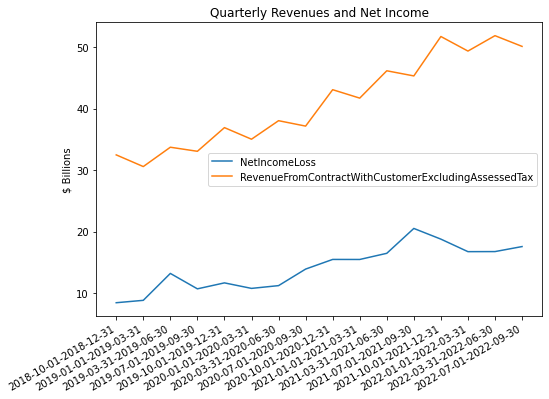

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

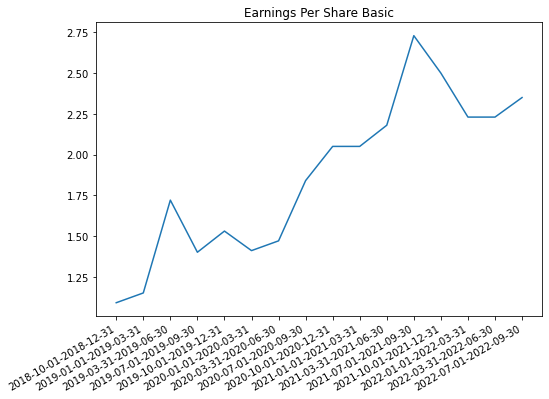

In [30]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float).loc["EarningsPerShareBasic"].plot.line()

ax.set_title('Earnings Per Share Basic')

# use higher precision for y axis labels
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

# AAPL